In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from TargetDistributions.DoubleWell import ManyWellEnergy
import torch
from FittedModels.utils.plotting_utils import plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_distribution
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils.plotting_utils import plot_history
import matplotlib.pyplot as plt
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well as plot_samples_vs_contours
torch.set_default_dtype(torch.float64)

In [6]:
def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours(*args, **kwargs)
    plt.show()

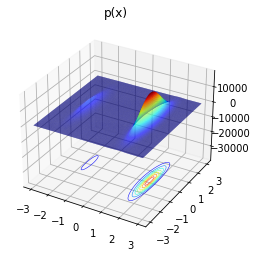

In [5]:
target = ManyWellEnergy(2, a=-0.5, b=-6)
dist = plot_distribution(target, bounds=[[-3, 3], [-3, 3]], n_points=300)
plt.show()

# Alpha=2

In [8]:
torch.manual_seed(1)
# ******************* Parameters *******************
dim = 2
epochs = int(5e3)
n_samples_estimation = int(1e5)
batch_size = int(1e3)
lr = 1e-3
optimizer = "Adam"
loss_type = "DReG"  # "kl"  #
initial_flow_scaling = 2.0
n_flow_steps = 30
annealing = True
flow_type = "RealNVP"
n_plots = 10

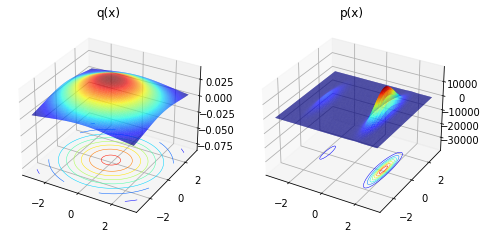

loss: -12.372653313804015, mean log p_x -27.021247349816573:   0%|                                                                                            | 0/5000 [00:00<?, ?it/s]

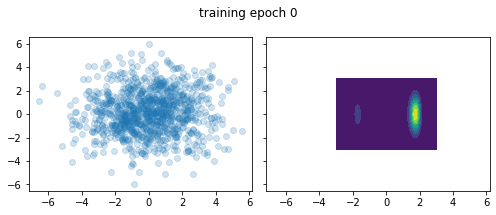

loss: 13.996727336115516, mean log p_x 7.251142899829587:  10%|████████▍                                                                            | 499/5000 [00:52<07:15, 10.33it/s]

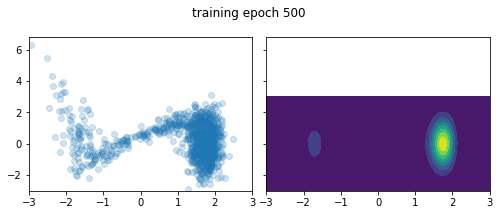

loss: 13.996727336115516, mean log p_x 7.251142899829587:  10%|████████▌                                                                            | 503/5000 [00:53<12:49,  5.84it/s]

ESS is 0.4170155431947353


loss: -10.464005207767588, mean log p_x 7.993067159232811:  20%|████████████████▌                                                                  | 1000/5000 [01:48<06:29, 10.28it/s]

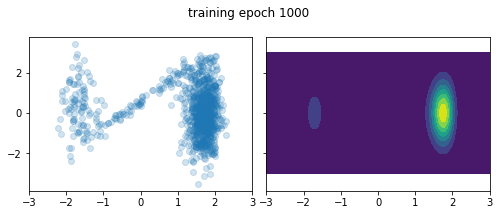

loss: -10.464005207767588, mean log p_x 7.993067159232811:  20%|████████████████▋                                                                  | 1002/5000 [01:49<12:26,  5.36it/s]

ESS is 0.5908241370654651


loss: -10.379765103234483, mean log p_x 8.192574437211071:  30%|████████████████████████▉                                                          | 1500/5000 [02:39<05:42, 10.22it/s]

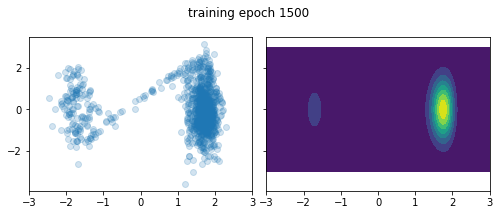

loss: -10.379765103234483, mean log p_x 8.192574437211071:  30%|████████████████████████▉                                                          | 1502/5000 [02:40<11:00,  5.30it/s]

ESS is 0.6769159465495186


loss: -10.389172320620515, mean log p_x 8.19140342293693:  40%|█████████████████████████████████▍                                                  | 1989/5000 [03:30<04:35, 10.91it/s]

Nan/Inf loss encountered


loss: -10.350491942752386, mean log p_x 8.293878545145173:  40%|█████████████████████████████████▏                                                 | 1999/5000 [03:31<04:48, 10.40it/s]

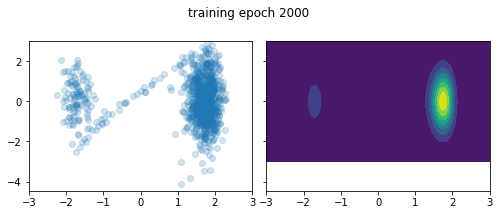

loss: -10.350491942752386, mean log p_x 8.293878545145173:  40%|█████████████████████████████████▏                                                 | 2002/5000 [03:32<09:06,  5.48it/s]

ESS is 0.7322649994943444


loss: -10.332583604931797, mean log p_x 8.425605869194504:  50%|█████████████████████████████████████████▍                                         | 2499/5000 [04:23<04:04, 10.22it/s]

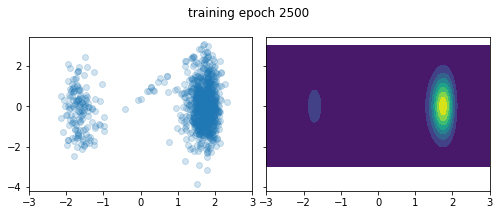

loss: -10.332583604931797, mean log p_x 8.425605869194504:  50%|█████████████████████████████████████████▌                                         | 2502/5000 [04:23<06:52,  6.06it/s]

ESS is 0.7697774485061908


loss: -10.326088132494249, mean log p_x 8.382622431860433:  56%|██████████████████████████████████████████████                                     | 2778/5000 [04:53<03:41, 10.04it/s]

In [ ]:
torch.manual_seed(0)  # 0
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps,
                           scaling_factor=initial_flow_scaling, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type=loss_type,
                                   lr=lr, optimizer=optimizer, annealing=annealing)

plot_samples_vs_contours(tester)
plt.show()
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)
plt.show()
history = tester.train(epochs, batch_size=batch_size, clip_grad_norm=True, max_grad_norm=1,
                       intermediate_plots=True, plotting_func=plotter, n_plots=n_plots)
plot_history(history)
plt.show()
plot_divergences(history)
plt.show()
plot_sampling_info(history)
plt.show()

expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)
plt.show()


# KL

In [ ]:
torch.manual_seed(1)
# ******************* Parameters *******************
dim = 2
epochs = int(1e4)
n_samples_estimation = int(1e5)
batch_size = int(1e3)
lr = 1e-3
optimizer = "Adam"
loss_type = "kl"
initial_flow_scaling = 2.0
n_flow_steps = 30
annealing = True
flow_type = "RealNVP"
n_plots = 10
def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours(*args, **kwargs)
    plt.show()

torch.manual_seed(0)  # 0
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps,
                           scaling_factor=initial_flow_scaling, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type=loss_type,
                                   lr=lr, optimizer=optimizer, annealing=annealing)

plot_samples_vs_contours(tester)
plt.show()
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)
plt.show()
history = tester.train(epochs, batch_size=batch_size, clip_grad_norm=True, max_grad_norm=1,
                       intermediate_plots=True, plotting_func=plotter, n_plots=n_plots)
plot_history(history)
plt.show()
plot_divergences(history)
plt.show()
plot_sampling_info(history)
plt.show()

expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")


